In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
table = read_csv('/content/drive/MyDrive/Thesis/csvs/NNdata14_20.csv')
table.head()

Date  IDStation         NameStation  Ammonia  Arsenic  \
0  2014-01-01T00:00:00Z        681  Moggio Loc Penscei      0.0      NaN   
1  2014-01-02T00:00:00Z        681  Moggio Loc Penscei      0.0      NaN   
2  2014-01-03T00:00:00Z        681  Moggio Loc Penscei      0.0      1.1   
3  2014-01-04T00:00:00Z        681  Moggio Loc Penscei      0.0      NaN   
4  2014-01-05T00:00:00Z        681  Moggio Loc Penscei      0.0      NaN   

   Benzo_a_pyrene  Cadmium  Lead  Nikel  NO  ...  IDStation.2  \
0             0.1      NaN   NaN    NaN NaN  ...          111   
1             NaN      NaN   NaN    NaN NaN  ...          111   
2             NaN      0.0   1.1    4.2 NaN  ...          111   
3             0.1      NaN   NaN    NaN NaN  ...          111   
4             NaN      NaN   NaN    NaN NaN  ...          111   

               NameStation.1  Wind_speed  Wind_direction  Temperature  \
0  Cassina Valsassina Moggio    0.443554            99.0    -0.334965   
1  Cassina Valsassina Moggio    0.355915           105.0    -0.486111   
2  Cassina Valsassina Moggio    0.207631           120.0     2.220588   
3  Cassina Valsassina Moggio    1.024926           175.0     2.137063   
4  Cassina Valsassina Moggio    0.666721            94.0     2.416084   

   Relative_humidity  Global_radiation Wind_speed_max  Wind_direction_max  \
0          45.545455         58.097902       1.805594               143.0   
1          83.944444          0.000000       1.767361               153.0   
2          87.042254         30.514085       1.558451               152.0   
3          89.349650          0.202797       3.816783               164.0   
4          86.055944         10.951049       2.797203               136.0   

  Rainfall  
0      0.0  
1      7.8  
2      0.0  
3     35.8  
4     25.0  

[5 rows x 28 columns]

In [5]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
#PM 2.5 were removed
Moggio = table.loc[:,["Date","PM10","Ammonia","Wind_speed","Wind_direction","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:-365,:] # we train not using 2020, for now
Moggio.head()


index                  Date  PM10  Ammonia  Wind_speed  Wind_direction  \
0      0  2014-01-01T00:00:00Z   6.0      0.0    0.443554            99.0   
1      1  2014-01-02T00:00:00Z   6.0      0.0    0.355915           105.0   
2      2  2014-01-03T00:00:00Z  11.0      0.0    0.207631           120.0   
3      3  2014-01-04T00:00:00Z   6.0      0.0    1.024926           175.0   
4      4  2014-01-05T00:00:00Z   3.0      0.0    0.666721            94.0   

   Temperature  Rainfall  
0    -0.334965       0.0  
1    -0.486111       7.8  
2     2.220588       0.0  
3     2.137063      35.8  
4     2.416084      25.0

In [6]:
# sns.lineplot(x='Date', y='PM25', data=Moggio)

##Convert series to supervised learning
### Activation function = tanh and logistic (s curve)

###Conversion Function

In [7]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Conversion of Moggio

In [8]:
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 2) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
#reframed.drop(reframed.columns[[31,32,33,34,35]], axis=1, inplace=True)

reframed.head()

var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  var5(t-5)  var6(t-5)  \
5   0.066667        0.0   0.163005   0.275000   0.286365   0.000000   
6   0.066667        0.0   0.130139   0.291667   0.282413   0.035199   
7   0.122222        0.0   0.074531   0.333333   0.353183   0.000000   
8   0.066667        0.0   0.381024   0.486111   0.350999   0.161552   
9   0.033333        0.0   0.246694   0.261111   0.358295   0.112816   

   var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  ...   var3(t)   var4(t)  \
5   0.066667        0.0   0.130139   0.291667  ...  0.075776  0.222222   
6   0.122222        0.0   0.074531   0.333333  ...  0.034263  0.150000   
7   0.066667        0.0   0.381024   0.486111  ...  0.201140  0.269444   
8   0.033333        0.0   0.246694   0.261111  ...  0.063516  0.100000   
9   0.022222        0.0   0.075776   0.222222  ...  0.141334  0.738889   

    var5(t)  var6(t)  var1(t+1)  var2(t+1)  var3(t+1)  var4(t+1)  var5(t+1)  \
5  0.406390      0.0   0.077778        0.0   0.034263   0.150000   0.397825   
6  0.397825      0.0   0.044444        0.0   0.201140   0.269444   0.408315   
7  0.408315      0.0   0.044444        0.0   0.063516   0.100000   0.392536   
8  0.392536      0.0   0.133333        0.0   0.141334   0.738889   0.409331   
9  0.409331      0.0   0.122222        0.0   0.068566   0.019444   0.387761   

   var6(t+1)  
5        0.0  
6        0.0  
7        0.0  
8        0.0  
9        0.0  

[5 rows x 42 columns]

In [9]:
reframed.iloc[:,-12:]

var1(t)  var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  var1(t+1)  \
5     0.022222      0.0  0.075776  0.222222  0.406390  0.000000   0.077778   
6     0.077778      0.0  0.034263  0.150000  0.397825  0.000000   0.044444   
7     0.044444      0.0  0.201140  0.269444  0.408315  0.000000   0.044444   
8     0.044444      0.0  0.063516  0.100000  0.392536  0.000000   0.133333   
9     0.133333      0.0  0.141334  0.738889  0.409331  0.000000   0.122222   
...        ...      ...       ...       ...       ...       ...        ...   
1730  0.044444      0.0  0.273680  0.488889  0.438365  0.011733   0.033333   
1731  0.033333      0.0  0.256569  0.547222  0.399272  0.193141   0.022222   
1732  0.022222      0.0  1.000000  0.605556  0.440144  0.378159   0.000000   
1733  0.000000      0.0  0.441052  0.558333  0.478401  0.073105   0.033333   
1734  0.033333      0.0  0.068348  0.100000  0.532473  0.000000   0.055556   

      var2(t+1)  var3(t+1)  var4(t+1)  var5(t+1)  var6(t+1)  
5           0.0   0.034263   0.150000   0.397825   0.000000  
6           0.0   0.201140   0.269444   0.408315   0.000000  
7           0.0   0.063516   0.100000   0.392536   0.000000  
8           0.0   0.141334   0.738889   0.409331   0.000000  
9           0.0   0.068566   0.019444   0.387761   0.000000  
...         ...        ...        ...        ...        ...  
1730        0.0   0.256569   0.547222   0.399272   0.193141  
1731        0.0   1.000000   0.605556   0.440144   0.378159  
1732        0.0   0.441052   0.558333   0.478401   0.073105  
1733        0.0   0.068348   0.100000   0.532473   0.000000  
1734        0.0   0.116845   0.472222   0.507234   0.000000  

[1730 rows x 12 columns]

In [10]:
# split into train and test sets
values = reframed.values
n_features = 6 # number of variables, including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -12:] #!!! -12 because we are predicting all 6 features for the the future 2 days (2*6=12)
test_X, test_y = test[:, :n_obs], test[:, -12:]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1312, 30) 1312 (1312, 12)
(1312, 5, 6) (1312, 12) (418, 5, 6) (418, 12)


# Modeling and training

Epoch 1/500
14/14 - 7s - loss: 0.2316 - val_loss: 0.2060 - 7s/epoch - 512ms/step
Epoch 2/500
14/14 - 0s - loss: 0.1510 - val_loss: 0.1281 - 224ms/epoch - 16ms/step
Epoch 3/500
14/14 - 0s - loss: 0.1132 - val_loss: 0.1156 - 249ms/epoch - 18ms/step
Epoch 4/500
14/14 - 0s - loss: 0.1073 - val_loss: 0.1116 - 235ms/epoch - 17ms/step
Epoch 5/500
14/14 - 0s - loss: 0.1038 - val_loss: 0.1084 - 241ms/epoch - 17ms/step
Epoch 6/500
14/14 - 0s - loss: 0.1022 - val_loss: 0.1068 - 230ms/epoch - 16ms/step
Epoch 7/500
14/14 - 0s - loss: 0.1007 - val_loss: 0.1050 - 260ms/epoch - 19ms/step
Epoch 8/500
14/14 - 0s - loss: 0.0996 - val_loss: 0.1033 - 233ms/epoch - 17ms/step
Epoch 9/500
14/14 - 0s - loss: 0.0995 - val_loss: 0.1021 - 233ms/epoch - 17ms/step
Epoch 10/500
14/14 - 0s - loss: 0.0999 - val_loss: 0.1009 - 236ms/epoch - 17ms/step
Epoch 11/500
14/14 - 0s - loss: 0.0992 - val_loss: 0.0996 - 258ms/epoch - 18ms/step
Epoch 12/500
14/14 - 0s - loss: 0.0984 - val_loss: 0.0996 - 246ms/epoch - 18ms/step
Epo

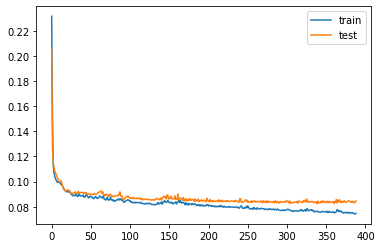

In [11]:
# design the neural network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(12))
model.compile(loss='mae', optimizer='adam')
# fit network
early_stopping = EarlyStopping(patience=50, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs=500, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=early_stopping)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Predictions of the year 2019

#### Prediciton plots

prediction with 2020

In [12]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
#PM 2.5 were removed
Moggio = table.loc[:,["Date","PM10","Ammonia","Wind_speed","Wind_direction","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:,:] # this is the differrence!!!!
Moggio.head()
values = Moggio.iloc[:,2:].values

# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 2) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
#reframed.drop(reframed.columns[[31,32,33,34,35]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
n_features = 6 # number of variables, including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -12:] #!!! -12 because we are predicting all 6 features for the the future 2 days (2*6=12)
test_X, test_y = test[:, :n_obs], test[:, -12:]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(1312, 30) 1312 (1312, 12)
(1312, 5, 6) (1312, 12) (783, 5, 6) (783, 12)


In [13]:
# make a prediction
yhat = model.predict(test_X)
#Convert from 3D to 2D
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))

In [14]:
# invert scaling for forecast
inv_yhatT2 =  scaler.inverse_transform(yhat[:,-6:])
inv_yhatT1 =  scaler.inverse_transform(yhat[:,:-6])
# invert scaling for actual
inv_yT2 = (scaler.inverse_transform(test_y[:,-6:]))
inv_yT1 = (scaler.inverse_transform(test_y[:,:-6]))

In [15]:
# calculate RMSE taking into account all variables at time step 1
rmse = sqrt(mean_squared_error(inv_yT1, inv_yhatT1))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 36.427


In [16]:
inv_yhat = inv_yhatT1[:,0] # prediction of PM10 (column 0) two time steps in the future 
inv_y = inv_yT1[:,0]  # actual PM10 (column 0) two time steps in the future 

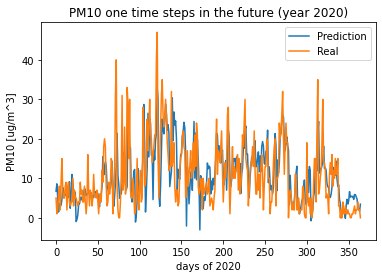

In [17]:
pyplot.plot(inv_yhat[-365:], label = 'Prediction')
pyplot.plot(inv_y[-365:], label = 'Real')
pyplot.legend()
pyplot.title("PM10 one time steps in the future (year 2020)")
pyplot.xlabel('days of 2020') 
pyplot.ylabel('PM10 [ug/m^3]') 
pyplot.show()

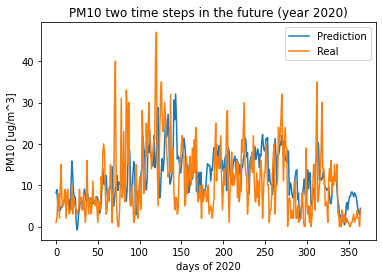

In [18]:
inv_yhat = inv_yhatT2[:,0] # prediction of PM10 (column 0) two time steps in the future 
inv_y = inv_yT2[:,0]  # actual PM10 (column 0) two time steps in the future 

pyplot.plot(inv_yhat[-365:], label = 'Prediction')
pyplot.plot(inv_y[-365:], label = 'Real')
pyplot.legend()
pyplot.title("PM10 two time steps in the future (year 2020)")
pyplot.xlabel('days of 2020') 
pyplot.ylabel('PM10 [ug/m^3]') 
pyplot.show()

# LIME

In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 4.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=d2cb5d9d9453644e77a06ccb68b6a176c8f3ba6c64195d67c39e39dfb8a3c844
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
from lime import lime_tabular

In [ ]:
test_X.shape

(784, 30)

In [ ]:
explainer = lime_tabular.RecurrentTabularExplainer(test_X, feature_names=["PM10","Ammonia","Wind_speed","Wind_direction","Temperature","Rainfall"], mode='regression')

In [ ]:
exp = explainer.explain_instance(test_X[50], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [ ]:
exp = explainer.explain_instance(test_X[49], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [ ]:
exp = explainer.explain_instance(test_X[75], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [ ]:
test_X[1]

array([[0.2       , 0.22772275, 0.34040976, 0.49166667, 0.8049929 ,
        0.01353791],
       [0.22222222, 0.2722772 , 0.3440421 , 0.35277778, 0.8189919 ,
        0.03158845],
       [0.23333333, 0.2821782 , 0.42023662, 0.49166667, 0.8296864 ,
        0.00270758],
       [0.24444444, 0.2772277 , 0.18730268, 0.5138889 , 0.7904489 ,
        0.02888086],
       [0.06666667, 0.25247523, 0.25320575, 0.5138889 , 0.8327731 ,
        0.        ]], dtype=float32)

In [ ]:
exp.as_list()

[('PM10_t-0 > 0.20', 0.0966388808011155),
 ('Ammonia_t-0 > 0.28', 0.05493249005082645),
 ('Rainfall_t-0 <= 0.00', 0.03244929237440714),
 ('PM10_t-1 > 0.20', -0.010809981922332903),
 ('Ammonia_t-1 > 0.28', -0.009527186622384996),
 ('0.56 < Temperature_t-0 <= 0.73', 0.005597394344111075)]